In [33]:
!pip install earthengine-api
!pip install folium

Para monitorar suas tasks entre no link abaixo e clique na aba Tasks na caixa à direta.

https://code.earthengine.google.com/


Autenticação por meio de uma conta do google cadastrada

In [34]:
# Import the Earth Engine Python Package
import ee

# Import the folium library.
import folium
from folium import plugins

# Trigger the authentication flow. You only need to do this once
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=gZK9NwoKA_ZVECu6nkk7EvUic81puu-zN5K6I__clt4&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/5QFhd5WKPMpmWaFOJkT4epoSTQlNcSdxeAxC7lPuSDAOyNdPDHM00d4

Successfully saved authorization token.


In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
#installing libgeo

!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
from mpl_toolkits.basemap import Basemap

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
  Using cached https://github.com/matplotlib/basemap/archive/master.zip
  Created wheel for basemap: filename=basemap-1.2.1-cp36-cp36m-linux_x86_64.whl size=121756186 sha256=a7047aae15416646420e800edae8b51db513edefffe7e4622ea208b68d95d476
  Stored in directory: /tmp/pip-ephem-wheel-cache-ma25krga/wheels/98/4a/fc/ce719b75d97e646645c225f3332b1b217536100314922e9572
Successfully built basemap


In [37]:
import time
import numpy as np
import matplotlib.pyplot as plt

In [38]:
#Add custom basemaps to folium

basemaps = {
    'Google Maps': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Maps',
        overlay = True,
        control = True
    ),
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Google Terrain': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Terrain',
        overlay = True,
        control = True
    ),
    'Google Satellite Hybrid': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Esri Satellite': folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = True,
        control = True
    )
}

Criando mapa para obter coordenadas

In [ ]:
# Create a folium map object.
my_map = folium.Map(location=[-15.7801, -47.9292], zoom_start=3, height=851)

# Add custom basemaps
basemaps['Google Maps'].add_to(my_map)
basemaps['Google Satellite Hybrid'].add_to(my_map)

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

folium.LatLngPopup().add_to(my_map)

# Display the map.
display(my_map)

Clique no mapa para obter as coordenadas do local escolhido. Em seguida, informe-as nas variáveis "Latitude" e "Longitude" abaixo. (Ou informe um um arquivo no formato shapefile).

Coordenadas:

In [84]:
Latitude= -7.46
Longitude= -64.47

shapefile = False
# shapefile = True


Configuração das informações do range de datas

In [86]:
dates = [['2019-01-01', '2019-03-31'], ['2019-04-01', '2019-06-30'], ['2019-07-01', '2019-09-30'], ['2019-10-01', '2019-12-31'], ['2020-01-01', '2020-03-31']]

Criação das tasks + Criação das listas de exceções

In [87]:
if shapefile:
  !pip install pyshp
  import shapefile

In [88]:
if shapefile:
  # Get coordinates from shapefile
  rec = shapefile.Reader("drive/My Drive/shapefile.shp")
  feature = rec.shapeRecords()[0]
  shape = feature.shape

  llx = shape.bbox[0]
  lly = shape.bbox[1]
  urx = shape.bbox[2]
  ury = shape.bbox[3]

  # rec = shapefile.Reader("drive/My Drive/shapefile.shp")
  # feature = rec.shapeRecords()[2]
  # rec = feature.record.as_dict()

  # bio = rec['Bioma']
  # id_a = rec['IDAlerta']
  # muni = rec['Municipio']
  # ano = rec['AnoDetec']

  # print(bio)
  # print(id_a)
  # print(muni)
  # print(ano)

else:
  # Get coordinates
  llx = Longitude - 0.0172
  lly = Latitude  - 0.0172
  urx = Longitude + 0.0172
  ury = Latitude  + 0.0172

# print(llx,lly,urx,ury)

# SENTINEL 1, SAR

count = 1
exception_list = []
exception_list2 = []

for day in dates:
        # if count % 100 == 0:
        #     print("waiting...")
        #     f = open("exception_list_problem.txt","w+")
        #     for task in exception_list2:
        #         f.write(task.__repr__()+"\n")
        #     f.close()
        #     time.sleep(15*60)
        # count += 1
        
        #Load the Sentinel-1 ImageCollection and filter to get images with VV and VH dual polarization
        sar = ee.ImageCollection('COPERNICUS/S1_GRD').filter(ee.Filter.eq('instrumentMode', 
            'IW')).filter(ee.Filter.listContains('transmitterReceiverPolarisation', 
            'VV')).filter(ee.Filter.listContains('transmitterReceiverPolarisation', 
            'VH'))
    
        #Filter to get images from different look angles and filter dates
        vhAscending = sar.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')).filterDate(day[0],day[1])
        vhDescending = sar.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING')).filterDate(day[0],day[1])
        
        #Create a composite from means at different polarizations and look angles.
        image = ee.Image.cat(
        [ee.ImageCollection(vhAscending.select('VH').merge(vhDescending.select('VH'))).mean(),
        ee.ImageCollection(vhAscending.select('VV').merge(vhDescending.select('VV'))).mean()]).focal_median()
        
       
        
        #Create Earth Engine polygon
        polygon = list([(llx,lly),(llx,ury),(urx,ury),(urx,lly)])
        geometry = ee.Geometry.Polygon(polygon)
        region = polygon
        im = image.clip(geometry)
    
        # file_name = str(Longitude) + '_' + str(Latitude) + '_' + day[0]
        file_name = str(llx)[:6] + "_" + str(lly)[:6] + "_" + day[0] + "_s1"

        print(file_name)
    
        task_config = { 
        'scale' : 10,
        'region': region,
        'folder':'GEE',
        'fileFormat':'GeoTIFF',
        'skipEmptyTiles' : True, 
        'maxPixels' : 1e13
        }
        
        try:
            # Send the task for the engine.
            task = ee.batch.Export.image.toDrive(im, file_name, **task_config)
            task.start()
            print("Task sent ")
        except:
            print("Error sending this task")
            exception_list.append(task)
            exception_list2.append(file_name)
            print("Size exception_list: ", len(exception_list))

# # SENTINEL 2, RGB

# for day in dates:
        
#         bands = ['B4', 'B3', 'B2']

#         def mask2clouds(image):
#                         cloudShadowBitMask = ee.Number(2).pow(3).int()
#                         cloudsBitMask = ee.Number(2).pow(5).int()
#                         qa = image.select('QA60')
#                         mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(
#                             qa.bitwiseAnd(cloudsBitMask).eq(0))
#                         return image.updateMask(mask).select(bands).divide(10000)

#         dataset = ee.ImageCollection('COPERNICUS/S2').filterDate(day[0], day[1]).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)).map(mask2clouds)

#         while ((dataset.size().getInfo() == 0) and (cloudy_percentage < 100)):
#           print("Do not exists images in this dataset using cloudy percentage equal to {}%".format(cloudy_percentage))
#           cloudy_percentage = cloudy_percentage + 10
#           print("Increasing cloudy_percentage to {}%".format(cloudy_percentage))
#           dataset = satellite.filterDate(day[0],day[1]).filter(ee.Filter.lte(flag_clouds, cloudy_percentage)).map(mask).filterBounds(ee.Geometry.Polygon(geometry))

#         image = dataset.median()

#         # image = ee.Image(collSent.reduce(ee.Reducer.median()))
        
#         #Create Earth Engine polygon
#         polygon = list([(llx,lly),(llx,ury),(urx,ury),(urx,lly)])
#         geometry = ee.Geometry.Polygon(polygon)
#         region = polygon
#         im = image.clip(geometry)
    
#         # file_name = str(Longitude) + '_' + str(Latitude) + '_' + day[0] + "_s2"
#         file_name = str(llx)[:6] + "_" + str(lly)[:6] + "_" + day[0] + "_s2"

#         print(file_name)
    
#         task_config = { 
#         'scale' : 10,
#         'region': region,
#         'folder':'GEE',
#         'fileFormat':'GeoTIFF',
#         'skipEmptyTiles' : True, 
#         'maxPixels' : 1e13
#         }
        
#         try:
#             # Send the task for the engine.
#             task = ee.batch.Export.image.toDrive(im, file_name, **task_config)
#             task.start()
#             print("Task sent ")
#         except:
#             print("Error sending this task")
#             exception_list.append(task)
#             exception_list2.append(file_name)
#             print("Size exception_list: ", len(exception_list))

      

-64.48_-7.477_2019-01-01_s1
Task sent 
-64.48_-7.477_2019-04-01_s1
Task sent 
-64.48_-7.477_2019-07-01_s1
Task sent 
-64.48_-7.477_2019-10-01_s1
Task sent 
-64.48_-7.477_2020-01-01_s1
Task sent 


Importando arquivo "models.py" que contém a declaração da rede e em seguida carregando os pesos com o arquivo "weights". Tais arquivos devem estar salvos no Google Drive.

In [94]:
! cp drive/My\ Drive/models.py models.py
import models as M
import skimage
import gdal
from skimage.io import imread, imsave
from skimage.transform import resize

In [95]:
def normalization(img, mean, std):
    img = (img-mean)/std
    img = ((img - np.min(img)) / (np.max(img)-np.min(img)))*255
    return img

def normalization_(img):
    img = ((img - np.min(img)) / (np.max(img)-np.min(img)))*255
    return img

def sliding_window(IMAGE, patch_size, stride):
    prediction = np.zeros((IMAGE.shape[1], IMAGE.shape[2]))
    sum_it = np.zeros((IMAGE.shape[1], IMAGE.shape[2]))
    x=0
    while (x!=IMAGE.shape[1]):
      y=0
      while (y!=IMAGE.shape[2]):
        if (not y+patch_size > IMAGE.shape[2]) and (not x+patch_size > IMAGE.shape[1]):
          patch = IMAGE[:, x:x + patch_size, y:y + patch_size, :]
          output = model.predict(patch, batch_size=1, verbose=0)
          output = output.squeeze()
          for i in range(0, patch_size):
              for j in range(0, patch_size):
                  prediction[x+i, y+j] += output[i,j]
                  sum_it[x+i, y+j] +=1
        if y + patch_size == IMAGE.shape[2]:
          break
        if y + patch_size > IMAGE.shape[2]:
          y = IMAGE.shape[2] - patch_size
        else:
          y = y+stride
      if x + patch_size == IMAGE.shape[1]:
        break
      if x + patch_size > IMAGE.shape[1]:
        x = IMAGE.shape[1] - patch_size
      else:
        x = x+stride
    return prediction*(1/sum_it)

dataset_mean_ind = (-15.34541179, -8.87553847)
dataset_std_ind = (1.53520544, 1.45585154)

if shapefile:
  model = M.BCDU_net_D3(input_size = (32,32,10))
else:
  model = M.BCDU_net_D3(input_size = (384,384,10))

model.summary()
model.load_weights('drive/My Drive/weights')

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 384, 384, 10 0                                            
__________________________________________________________________________________________________
conv2d_160 (Conv2D)             (None, 384, 384, 64) 5824        input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_161 (Conv2D)             (None, 384, 384, 64) 36928       conv2d_160[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_24 (MaxPooling2D) (None, 192, 192, 64) 0           conv2d_161[0][0]                 
______________________________________________________________________________________

Normalizando as imagens da série temporal baixada pelo earth engine, concatenando-as e em seguida fornecendo-as como input para a rede.

In [96]:
if shapefile:
  img1  = normalization(np.moveaxis(gdal.Open("drive/My Drive/GEE/" + str(llx)[:6] + "_" + str(lly)[:6] + "_" + "2019-01-01_s1.tif").ReadAsArray(), 0, -1), mean=dataset_mean_ind, std=dataset_std_ind)
  img2  = normalization(resize(np.moveaxis(gdal.Open("drive/My Drive/GEE/"+ str(llx)[:6] + "_" + str(lly)[:6] + "_" + "2019-04-01_s1.tif").ReadAsArray(), 0, -1), (img1.shape[0],img1.shape[1])), mean=dataset_mean_ind, std=dataset_std_ind)
  img3  = normalization(resize(np.moveaxis(gdal.Open("drive/My Drive/GEE/"+ str(llx)[:6] + "_" + str(lly)[:6] + "_" + "2019-07-01_s1.tif").ReadAsArray(), 0, -1), (img1.shape[0],img1.shape[1])), mean=dataset_mean_ind, std=dataset_std_ind)
  img4  = normalization(resize(np.moveaxis(gdal.Open("drive/My Drive/GEE/"+ str(llx)[:6] + "_" + str(lly)[:6] + "_" + "2019-10-01_s1.tif").ReadAsArray(), 0, -1), (img1.shape[0],img1.shape[1])), mean=dataset_mean_ind, std=dataset_std_ind)
  img5  = normalization(resize(np.moveaxis(gdal.Open("drive/My Drive/GEE/"+ str(llx)[:6] + "_" + str(lly)[:6] + "_" + "2020-01-01_s1.tif").ReadAsArray(), 0, -1), (img1.shape[0],img1.shape[1])), mean=dataset_mean_ind, std=dataset_std_ind)
else:
  img1  = normalization(resize(np.moveaxis(gdal.Open("drive/My Drive/GEE/"+ str(llx)[:6] + "_" + str(lly)[:6] + "_" + "2019-01-01_s1.tif").ReadAsArray(), 0, -1), (384,384)), mean=dataset_mean_ind, std=dataset_std_ind)
  img2  = normalization(resize(np.moveaxis(gdal.Open("drive/My Drive/GEE/"+ str(llx)[:6] + "_" + str(lly)[:6] + "_" + "2019-04-01_s1.tif").ReadAsArray(), 0, -1), (384,384)), mean=dataset_mean_ind, std=dataset_std_ind)
  img3  = normalization(resize(np.moveaxis(gdal.Open("drive/My Drive/GEE/"+ str(llx)[:6] + "_" + str(lly)[:6] + "_" + "2019-07-01_s1.tif").ReadAsArray(), 0, -1), (384,384)), mean=dataset_mean_ind, std=dataset_std_ind)
  img4  = normalization(resize(np.moveaxis(gdal.Open("drive/My Drive/GEE/"+ str(llx)[:6] + "_" + str(lly)[:6] + "_" + "2019-10-01_s1.tif").ReadAsArray(), 0, -1), (384,384)), mean=dataset_mean_ind, std=dataset_std_ind)
  img5  = normalization(resize(np.moveaxis(gdal.Open("drive/My Drive/GEE/"+ str(llx)[:6] + "_" + str(lly)[:6] + "_" + "2020-01-01_s1.tif").ReadAsArray(), 0, -1), (384,384)), mean=dataset_mean_ind, std=dataset_std_ind)

data = np.concatenate((img1,img2,img3,img4,img5),axis=2)
data  = np.expand_dims(data, axis=0)

print(data.shape)

if shapefile:
  # dimensões da imagem devem ter pelo menos 32 pixels
  pred = sliding_window(data, patch_size = 32, stride = 8)
else:
  pred = model.predict(data, batch_size=1, verbose=0)

predbin = np.where(pred >0.5, 1, 0)

(1, 384, 384, 10)


Exibindo resultados


Localização:



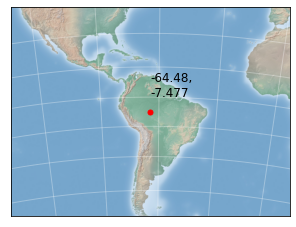


Predição:



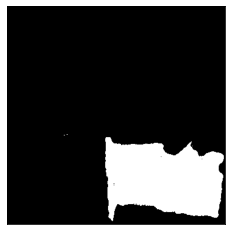

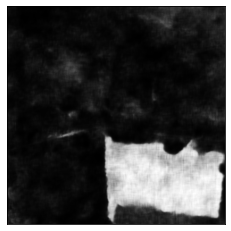


Série Temporal:



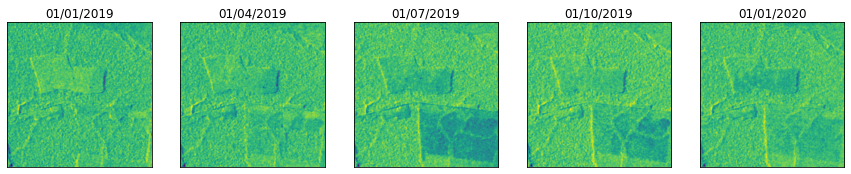

In [97]:
from itertools import chain

def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    m.shadedrelief(scale=scale)
    
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

print("Localização:\n")
fig = plt.figure(figsize=(5, 5))
m = Basemap(projection='lcc', resolution=None,
            lon_0=llx, lat_0=lly, lat_1=lly, lat_2=lly,
            width=1.6E7, height=1.2E7)
draw_map(m)

# Map (long, lat) to (x, y) for plotting
x, y = m(llx, lly)
plt.plot(x, y, 'ok', markersize=5, color='red')
plt.text(x, y, str(llx)[:6] + ",\n" + str(lly)[:6] + "\n", fontsize=12);

plt.show()

print("\nPredição:\n")

# prediction

fig = plt.figure(figsize=(4, 4))

plt.imshow(np.squeeze(predbin), cmap='gray')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)

plt.show()

# probability map

fig = plt.figure(figsize=(4, 4))

plt.imshow(np.squeeze(pred), cmap='gray')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)

plt.show()

print("\nSérie Temporal:\n")
fig, axes = plt.subplots(1,5,figsize=[15,5])
ax = axes.ravel()

ax[0].imshow(np.uint8(img1[:,:,0]))
ax[1].imshow(np.uint8(img2[:,:,0]))
ax[2].imshow(np.uint8(img3[:,:,0]))
ax[3].imshow(np.uint8(img4[:,:,0]))
ax[4].imshow(np.uint8(img5[:,:,0]))

ax[0].set_title("01/01/2019")
ax[1].set_title("01/04/2019")
ax[2].set_title("01/07/2019")
ax[3].set_title("01/10/2019")
ax[4].set_title("01/01/2020")

for i in range(0,5):
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    ax[i].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)

plt.show()

## RGB 

# img1s2  = normalization_(np.moveaxis(gdal.Open("drive/My Drive/GEE/"+ str(llx)[:6] + "_" + str(lly)[:6] + "_" + "2019-01-01_s2.tif").ReadAsArray(), 0, -1))
# img2s2  = normalization_(np.moveaxis(gdal.Open("drive/My Drive/GEE/"+ str(llx)[:6] + "_" + str(lly)[:6] + "_" + "2019-04-01_s2.tif").ReadAsArray(), 0, -1))
# img3s2  = normalization_(np.moveaxis(gdal.Open("drive/My Drive/GEE/"+ str(llx)[:6] + "_" + str(lly)[:6] + "_" + "2019-07-01_s2.tif").ReadAsArray(), 0, -1))
# img4s2  = normalization_(np.moveaxis(gdal.Open("drive/My Drive/GEE/"+ str(llx)[:6] + "_" + str(lly)[:6] + "_" + "2019-10-01_s2.tif").ReadAsArray(), 0, -1))
# img5s2  = normalization_(np.moveaxis(gdal.Open("drive/My Drive/GEE/"+ str(llx)[:6] + "_" + str(lly)[:6] + "_" + "2020-01-01_s2.tif").ReadAsArray(), 0, -1))

# print("\nRGB:\n")
# fig, axes = plt.subplots(1,5,figsize=[15,5])
# ax = axes.ravel()

# ax[0].imshow(np.uint8(img1s2))
# ax[1].imshow(np.uint8(img2s2))
# ax[2].imshow(np.uint8(img3s2))
# ax[3].imshow(np.uint8(img4s2))
# ax[4].imshow(np.uint8(img5s2))


# for i in range(0,5):
#     ax[i].set_yticklabels([])
#     ax[i].set_xticklabels([])
#     ax[i].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)

# plt.show()
